In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers

In [2]:
movies_data = pd.read_csv("movies.csv")
ratings_data = pd.read_csv("ratings.csv")

In [3]:
movies_data["genres"] = [eval(s) for s in movies_data["genres"]]
unique_genres = set()
for genres in movies_data["genres"]:
    unique_genres.update(genres)

unique_genres = sorted(list(unique_genres))
# print(unique_genres)

# One-hot encode genres for each movie
for unique_value in unique_genres:
    movies_data[unique_value] = movies_data.apply(
        lambda row: 1 if unique_value in movies_data["genres"][row.name] else 0, axis=1
    )

In [5]:
class MovieRecommender:
    def __init__(self, movies_df, ratings_df, embedding_dim=100):
        self.movies_df = movies_df
        self.ratings_df = ratings_df
        self.embedding_dim = embedding_dim

        # Initialize encoders and scalers
        self.user_encoder = LabelEncoder()
        self.movie_encoder = LabelEncoder()
        self.rating_scaler = MinMaxScaler()

        # Define genre columns explicitly
        self.genre_columns = [
            "Action",
            "Adventure",
            "Animation",
            "Comedy",
            "Crime",
            "Documentary",
            "Drama",
            "Family",
            "Fantasy",
            "History",
            "Horror",
            "Music",
            "Mystery",
            "Romance",
            "Science Fiction",
            "TV Movie",
            "Thriller",
            "War",
            "Western",
        ]

        # Prepare data
        self.prepare_data()

        # Build model
        self.model = self.build_model()

    def prepare_data(self):
        # Encode users and movies
        self.ratings_df["user_encoded"] = self.user_encoder.fit_transform(
            self.ratings_df["user_id"]
        )
        self.ratings_df["movie_encoded"] = self.movie_encoder.fit_transform(
            self.ratings_df["movie_id"]
        )

        # Scaling ratings to [0,1] range
        self.ratings_df["rating_scaled"] = self.rating_scaler.fit_transform(
            self.ratings_df[["rating_val"]]
        )

        self.global_mean = self.ratings_df["rating_val"].mean()
        self.user_means = self.ratings_df.groupby("user_encoded")["rating_val"].mean()
        self.movie_means = self.ratings_df.groupby("movie_encoded")["rating_val"].mean()

        self.n_users = len(self.user_encoder.classes_)
        self.n_movies = len(self.movie_encoder.classes_)

        self.prepare_genre_features()

    def prepare_genre_features(self):
        for genre in self.genre_columns:
            if genre not in self.movies_df.columns:
                self.movies_df[genre] = 0
        self.genre_features = self.movies_df[self.genre_columns].fillna(0).values
        self.n_genres = len(self.genre_columns)

    def cosine_similarity_metric(self, y_true, y_pred):
        y_true_norm = tf.nn.l2_normalize(y_true, axis=-1)
        y_pred_norm = tf.nn.l2_normalize(y_pred, axis=-1)

        cosine_similarity = tf.reduce_sum(
            tf.multiply(y_true_norm, y_pred_norm), axis=-1
        )

        return tf.reduce_mean(cosine_similarity)

    def build_model(self):
        user_input = tf.keras.layers.Input(shape=(1,), name="user_input")
        movie_input = tf.keras.layers.Input(shape=(1,), name="movie_input")
        genre_input = tf.keras.layers.Input(shape=(self.n_genres,), name="genre_input")

        # Embedding layers
        user_embedding = tf.keras.layers.Embedding(
            self.n_users,
            self.embedding_dim,
            embeddings_regularizer=regularizers.l2(0.001),
            name="user_embedding",
        )(user_input)
        movie_embedding = tf.keras.layers.Embedding(
            self.n_movies,
            self.embedding_dim,
            embeddings_regularizer=regularizers.l2(0.001),
            name="movie_embedding",
        )(movie_input)

        user_vector = tf.keras.layers.Flatten()(user_embedding)
        movie_vector = tf.keras.layers.Flatten()(movie_embedding)

        user_vector = tf.keras.layers.Dense(128, activation="relu")(user_vector)
        movie_vector = tf.keras.layers.Dense(128, activation="relu")(movie_vector)

        genre_dense = tf.keras.layers.Dense(32, activation="relu")(genre_input)

        merged = tf.keras.layers.Concatenate()([user_vector, movie_vector, genre_dense])

        # Dense layers with dropout and batch normalization
        dense1 = tf.keras.layers.Dense(128, activation="relu")(merged)
        dense1 = tf.keras.layers.BatchNormalization()(dense1)
        dense1 = tf.keras.layers.Dropout(0.3)(dense1)

        dense2 = tf.keras.layers.Dense(64, activation="relu")(dense1)
        dense2 = tf.keras.layers.BatchNormalization()(dense2)
        dense2 = tf.keras.layers.Dropout(0.3)(dense2)

        dense3 = tf.keras.layers.Dense(32, activation="relu")(dense2)
        dense3 = tf.keras.layers.BatchNormalization()(dense3)

        output = tf.keras.layers.Dense(1, activation="linear")(
            dense3
        )  # Changed to linear activation for regression

        model = tf.keras.Model(
            inputs=[user_input, movie_input, genre_input], outputs=output
        )

        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

        model.compile(
            optimizer=optimizer,
            loss="mean_squared_error",
            metrics=["mae", "mse", self.cosine_similarity_metric],
        )

        return model

    def train(self, epochs=100, batch_size=64):
        X_users = self.ratings_df["user_encoded"].values
        X_movies = self.ratings_df["movie_encoded"].values
        y = self.ratings_df["rating_scaled"].values

        movie_indices = self.movie_encoder.transform(self.ratings_df["movie_id"])
        X_genres = self.genre_features[movie_indices]

        print(f"X_users shape: {X_users.shape}")
        print(f"X_movies shape: {X_movies.shape}")
        print(f"X_genres shape: {X_genres.shape}")

        X_users = X_users.astype(np.int32)
        X_movies = X_movies.astype(np.int32)
        X_genres = X_genres.astype(np.float32)

        # Train-test split
        (
            X_users_train,
            X_users_test,
            X_movies_train,
            X_movies_test,
            X_genres_train,
            X_genres_test,
            y_train,
            y_test,
        ) = train_test_split(
            X_users, X_movies, X_genres, y, test_size=0.2, random_state=42
        )

        X_users_train = X_users_train.reshape(-1, 1)
        X_movies_train = X_movies_train.reshape(-1, 1)

        print(f"X_users_train shape: {X_users_train.shape}")
        print(f"X_movies_train shape: {X_movies_train.shape}")
        print(f"X_genres_train shape: {X_genres_train.shape}")

        callbacks = [
            EarlyStopping(
                monitor="val_loss",
                patience=10,
                restore_best_weights=True,
                min_delta=0.001,
            ),
            ReduceLROnPlateau(
                monitor="val_loss", factor=0.5, patience=4, min_lr=0.00001
            ),
        ]

        history = self.model.fit(
            [X_users_train, X_movies_train, X_genres_train],
            y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=([X_users_test, X_movies_test, X_genres_test], y_test),
            callbacks=callbacks,
            verbose=1,
        )

        return history

    def get_recommendations(self, movie_name, top_k=10):
        try:
            movie_idx = self.movie_encoder.transform([movie_name])[0]
            movie_genres = self.genre_features[movie_idx]

            # Generate recommendations based on all users
            all_movies = np.arange(self.n_movies)
            all_predictions = []

            for user_idx in range(self.n_users):
                user_input = np.full(self.n_movies, user_idx)
                genre_input = self.genre_features
                predictions = self.model.predict([user_input, all_movies, genre_input])
                all_predictions.append(predictions.flatten())

            # Aggregate predictions and recommend the top K
            mean_predictions = np.mean(all_predictions, axis=0)
            top_movie_indices = np.argsort(mean_predictions)[::-1]

            recommended_movies = []
            for idx in top_movie_indices:
                if idx != movie_idx:
                    movie_id = self.movie_encoder.inverse_transform([idx])[0]
                    recommended_movies.append(movie_id)
                    if len(recommended_movies) == top_k:
                        break

            return recommended_movies

        except ValueError:
            print(f"Movie '{movie_name}' not found in the dataset.")
            return []

In [6]:
def create_recommender(movies_df, ratings_df):
    recommender = MovieRecommender(movies_df, ratings_df)
    history = recommender.train(100, 64)
    return recommender, history

In [7]:
recommender, history = create_recommender(movies_data, ratings_data)

X_users shape: (389798,)
X_movies shape: (389798,)
X_genres shape: (389798, 19)
X_users_train shape: (311838, 1)
X_movies_train shape: (311838, 1)
X_genres_train shape: (311838, 19)
Epoch 1/100


c:\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['user_input', 'movie_input', 'genre_input']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


4873/4873 ━━━━━━━━━━━━━━━━━━━━ 140s 27ms/step - cosine_similarity_metric: 6.6539 - loss: 0.2234 - mae: 0.2633 - mse: 0.1441 - val_cosine_similarity_metric: 7.2398 - val_loss: 0.0538 - val_mae: 0.1582 - val_mse: 0.0390 - learning_rate: 0.0010
Epoch 2/100
4873/4873 ━━━━━━━━━━━━━━━━━━━━ 151s 31ms/step - cosine_similarity_metric: 7.2372 - loss: 0.0501 - mae: 0.1555 - mse: 0.0382 - val_cosine_similarity_metric: 7.2398 - val_loss: 0.0477 - val_mae: 0.1527 - val_mse: 0.0362 - learning_rate: 0.0010
Epoch 3/100
4873/4873 ━━━━━━━━━━━━━━━━━━━━ 184s 38ms/step - cosine_similarity_metric: 7.2352 - loss: 0.0451 - mae: 0.1467 - mse: 0.0345 - val_cosine_similarity_metric: 7.2341 - val_loss: 0.0419 - val_mae: 0.1466 - val_mse: 0.0341 - learning_rate: 0.0010
Epoch 4/100
4873/4873 ━━━━━━━━━━━━━━━━━━━━ 169s 35ms/step - cosine_similarity_metric: 7.2345 - loss: 0.0430 - mae: 0.1453 - mse: 0.0339 - val_cosine_similarity_metric: 7.2396 - val_loss: 0.0441 - val_mae: 0.1462 - val_mse: 0.0354 - learning_rate: 0.0

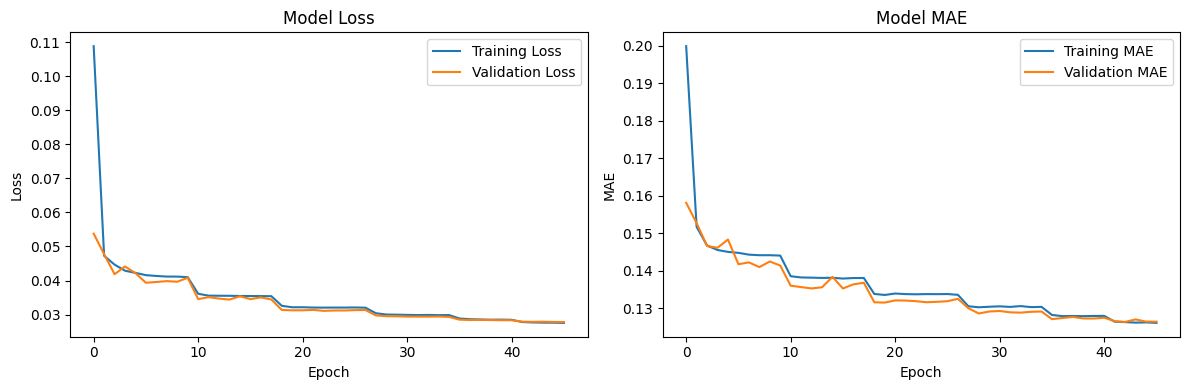

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["mae"], label="Training MAE")
plt.plot(history.history["val_mae"], label="Validation MAE")
plt.title("Model MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
movie_name = "the-dark-knight"
recommended_movies = recommender.get_recommendations(movie_name, top_k=10)

print("Top 10 recommended movies for:", movie_name)
print(recommended_movies)